In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
from sklearn.feature_selection import RFE, SelectFromModel, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
X, y, feature_names, _, _ = load_boston().values()

In [3]:
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X, columns = feature_names), pd.Series(y, name='label'), test_size = .2, random_state=42)

In [4]:
X_train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
477,15.02340,0.0,18.10,0.0,0.6140,5.304,97.3,2.1007,24.0,666.0,20.2,349.48,24.91
15,0.62739,0.0,8.14,0.0,0.5380,5.834,56.5,4.4986,4.0,307.0,21.0,395.62,8.47
332,0.03466,35.0,6.06,0.0,0.4379,6.031,23.3,6.6407,1.0,304.0,16.9,362.25,7.83
423,7.05042,0.0,18.10,0.0,0.6140,6.103,85.1,2.0218,24.0,666.0,20.2,2.52,23.29
19,0.72580,0.0,8.14,0.0,0.5380,5.727,69.5,3.7965,4.0,307.0,21.0,390.95,11.28


# 필터 기법

+ 특정 모델링 기법에 의존하지 않고 데이터의 통계적 특성으로부터 변수를 선택하는 기법
+ 계산속도가 빠르다.

## 상관계수

<AxesSubplot:>

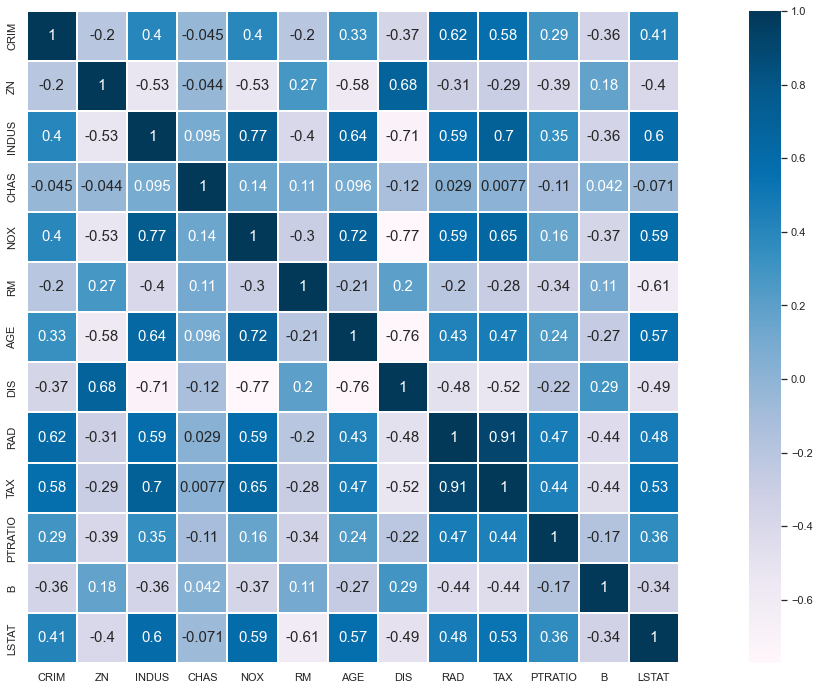

In [5]:
sns.set(rc = {'figure.figsize':(25, 12)})
sns.heatmap(X_train.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = plt.cm.PuBu, linecolor = "white", annot = True, annot_kws = {"size" : 15})

# 래퍼 기법

+ 변수의 일부만을 모델링에 사용하고 그 결과를 확인하는 작업을 반복하며 변수를 선택하는 기법
+ 그리디 알고리즘을 사용하므로 최적해는 아니다.
+ 필터 기법보다는 예측 정확도가 높지만 과적합의 가능성이 있다.

In [6]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
model_lr = LinearRegression()

## RFE (Recursive Feature Elimination)

+ 트리 기반 모델이면 feature importance, 선형 모델 혹은 SVM이면 coefficient의 절댓값이 가장 작은 변수를 알고리즘을 사용하여 재귀적으로 제거

In [8]:
rfe = RFE(estimator=model_lr, n_features_to_select=0.5)
rfe.fit(X_train, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=0.5)

In [9]:
print(rfe.ranking_)

[4 6 7 5 1 1 8 1 2 1 1 3 1]


+ 변수 중요도에 대한 순위를 나타냄   
+ n_features_to_select를 통해 0~1 사이의 비율 또는 1이상의 정수로 개수를 우선순위를 지정할 수 있다.

## SFS (Sequencial Feature Selection)
+ 알고리즘(전진선택, 후진제거)을 사용하여 하나씩 추가 또는 제거

In [10]:
sfs = SequentialFeatureSelector(estimator=model_lr, cv = 3, direction='forward', scoring='r2')
sfs.fit(X_train, y_train)

SequentialFeatureSelector(cv=3, estimator=LinearRegression(), scoring='r2')

In [11]:
print(sfs.support_)

[False False False False  True  True False  True False False  True  True
  True]


# 임베디드 기법
+ 모델 자체에 변수 선택이 포함된 기법
+ 모델에 정확도에 기여하는 변수를 학습

## 라쏘 회귀
+ 가중치 절댓값의 합을 최소화 (L1 penalty)
+ 어떤 변수는 가중치가 0

In [12]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

Lasso(alpha=0.1)

In [13]:
print(lasso.coef_)

[-0.71836455  0.25962714 -0.          0.69822096 -1.56814243  3.27150693
 -0.         -2.28444944  0.67193802 -0.3566537  -1.89333519  1.03136581
 -3.60941047]


## 릿지 회귀
+ 가중치 제곱합을 최소화 (L2 penalty)

In [14]:
ridge = Ridge(alpha=1, solver='cholesky')
ridge.fit(X_train, y_train)

Ridge(alpha=1, solver='cholesky')

In [15]:
print(ridge.coef_)

[-0.99218679  0.6777488   0.2522143   0.72248078 -1.99083465  3.15157218
 -0.17726162 -3.04502895  2.17324941 -1.69555879 -2.02783351  1.127197
 -3.59897667]


## 엘라스틱 넷
+ L1, L2 penalty를 모두 사용

In [16]:
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X_train, y_train)

ElasticNet(alpha=0.1)

In [17]:
print(elastic_net.coef_)

[-0.76122098  0.32222666 -0.03100814  0.73691319 -1.39595306  3.23360553
 -0.09611142 -2.17591861  0.84653681 -0.62395172 -1.83004132  1.04033648
 -3.4038305 ]


##  Select From Model
+ 의사결정나무 기반으로 변수선택

In [18]:
sfm = SelectFromModel(estimator=model_lr, threshold= 'mean')
sfm.fit(X_train, y_train)

SelectFromModel(estimator=LinearRegression(), threshold='mean')

In [19]:
print(sfm.get_support())

[False False False False  True  True False  True  True  True  True False
  True]
